# Neanderthal vs Human Genomes - VCF Exercise, Wk3 Topics in Bioinformatics 
Madison Dautle
Created on 09.16.2025 
Last updated on 09.16.2025

In [144]:
import os
import subprocess 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from itertools import product 
import numpy as np

In [145]:
#Download and unpack file, if necessary 
file_path = "AltaiNea.hg19_1000g.22.mod.vcf"
gz_path = file_path + '.gz'
chunk_size = 100000

if not os.path.exists(file_path): 
    if not os.path.exists(gz_path):
        download = 'wget http://cdna.eva.mpg.de/neandertal/altai/AltaiNeandertal/VCF/AltaiNea.hg19_1000g.22.mod.vcf.gz' 
        os.system(download)
        
    unzip = f'gunzip -k {file_path}.gz' 
    os.system(unzip)

In [146]:
#get information about file to set up dataframes to hold results
command = f"""awk -F'\t' '
  $0 !~ /^#/ {{
    if (first == "") first = $0
    last = $0
  }}
  END {{
    print first
    print last
  }}
' "{file_path}" """

start_end_lines= subprocess.run(command, shell=True, capture_output=True, text=True)
min_pos_line, max_pos_line = start_end_lines.stdout.strip().split("\n")
min_pos = int(min_pos_line.split("\t")[1])
max_pos = int(max_pos_line.split("\t")[1])
total_length = max_pos-min_pos
num_chunks = math.ceil(total_length/chunk_size)

print("Minimum postion:" , min_pos)
print("Maximum position:", max_pos)
print("Length to split:", total_length)
print(f"Total {chunk_size} chunks to process:", num_chunks)  

Minimum postion: 16050037
Maximum position: 51244566
Length to split: 35194529
Total 100000 chunks to process: 352


In [147]:
#initalize dataframes for result storage
chunk_pos_df = pd.DataFrame({
    'chunk': range(1,num_chunks+1),
    'start_pos': [min_pos + i*chunk_size for i in range(num_chunks)], 
    'end_pos': [min(min_pos + (i+1)*chunk_size -1, max_pos) for i in range(num_chunks)],
    'total_variation_ct': 0,
    'SNP_ct': 0,
    'neanderthal_indel_ct': 0,
    'human_indel_ct': 0
}) 
print(chunk_pos_df.head())

nucleotides = ['A','C','T','G']
nucleotide_pairs = list(product(nucleotides, repeat=2))
nucleotide_pairs = [(k, '.' if k == j else j) for k, j in nucleotide_pairs]
SNP_type_df = pd.DataFrame(0, index=nucleotides, columns=nucleotides)
print(SNP_type_df)
print(nucleotide_pairs)

   chunk  start_pos   end_pos  total_variation_ct  SNP_ct  \
0      1   16050037  16150036                   0       0   
1      2   16150037  16250036                   0       0   
2      3   16250037  16350036                   0       0   
3      4   16350037  16450036                   0       0   
4      5   16450037  16550036                   0       0   

   neanderthal_indel_ct  human_indel_ct  
0                     0               0  
1                     0               0  
2                     0               0  
3                     0               0  
4                     0               0  
   A  C  T  G
A  0  0  0  0
C  0  0  0  0
T  0  0  0  0
G  0  0  0  0
[('A', '.'), ('A', 'C'), ('A', 'T'), ('A', 'G'), ('C', 'A'), ('C', '.'), ('C', 'T'), ('C', 'G'), ('T', 'A'), ('T', 'C'), ('T', '.'), ('T', 'G'), ('G', 'A'), ('G', 'C'), ('G', 'T'), ('G', '.')]


In [148]:
start_time = time.time()
vcf=pd.read_csv(file_path, comment='#', sep='\t', usecols=[1,3,4], header = None)
vcf.columns = ['pos','Human','Neanderthal']
vcf.head()
end_time = time.time() 
print(f"Time to read file: {(end_time-start_time)} sec")
total_vcf_rows = len(vcf)
print(f"Total number of rows in VCF file: {total_vcf_rows}")
missing_vcf_rows_byPos = print(f"Total number of missing rows by position: {total_length - total_vcf_rows}")

Time to read file: 12.50005292892456 sec
Total number of rows in VCF file: 34862833
Total number of missing rows by position: 331696


In [149]:
start_time = time.time()
for idx, row in chunk_pos_df.iterrows():
    #select rows in this chunk
    chunk_rows = vcf[(vcf['pos'] >= row['start_pos']) & (vcf['pos'] <= row['end_pos'])]
    #count total SNPs in chunk by counting how many rows do not have the same (.) as the reference (Neanderthal column)
    chunk_var = chunk_rows[(chunk_rows['Neanderthal'] != '.')]
    variation_ct = len(chunk_var)
    chunk_pos_df.at[idx, 'total_variation_ct'] = variation_ct

    
    #SNP count - binned
    snp_count = ((chunk_rows['Neanderthal'].isin(nucleotides))).sum()
    chunk_pos_df.at[idx, 'SNP_ct'] = snp_count

    #neanderthal indel count - binned
    neanderthal_indel_count = ((chunk_rows['Neanderthal'] != '.') & 
                       (chunk_rows['Neanderthal'].str.len() > 1)).sum()
    chunk_pos_df.at[idx, 'neanderthal_indel_ct'] = neanderthal_indel_count

    # Human indel count - binned
    human_indel_count = ((chunk_rows['Neanderthal'].isin(nucleotides)) & 
                         (chunk_rows['Human'].str.len() > 1)).sum()
    chunk_pos_df.at[idx, 'human_indel_ct'] = human_indel_count

    
    #SNP type indentification and counting
    for human_letter, neanderthal_letter in nucleotide_pairs: 
        SNP_type_rows = chunk_rows[(chunk_rows['Human'] == human_letter) & (chunk_rows['Neanderthal'] == neanderthal_letter)]
        if neanderthal_letter == '.':
            neanderthal_letter=human_letter
        SNP_type_df.at[human_letter, neanderthal_letter] += len(SNP_type_rows)

total_variable_positions = chunk_pos_df['SNP_ct'].sum()
positions_in_SNP_type_df = SNP_type_df.sum().sum()
SNPs_in_SNP_type_df = SNP_type_df.values.sum() - np.trace(SNP_type_df.values)

end_time = time.time() 

#print(chunk_pos_df)
print(f"Total SNPs + indels: {total_variable_positions}")
print(SNP_type_df)
print(f"Positions captured in SNP_type_df: {positions_in_SNP_type_df}") 
print(f"SNPs captured in SNP_type_df: {SNPs_in_SNP_type_df}") #sanity check. Should match the total_snps
print(f"Time to count & classify SNPs: {(end_time-start_time)/60} min")

Total SNPs + indels: 81772
         A        C        T        G
A  9065898     3229     3137    11693
C     3511  8345612    12762     3338
T     3037    11495  9024951     3243
G    12756     3481     3419  8339632
Positions captured in SNP_type_df: 34851194
SNPs captured in SNP_type_df: 75101
Time to count & classify SNPs: 0.7262681365013123 min


In [150]:
nucleotides.append('.')
mismatch_rows_neanderthal = vcf[(~vcf['Neanderthal'].isin(nucleotides))]; print(mismatch_rows_neanderthal.head(5))
mismatch_rows_human = vcf[(~vcf['Human'].isin(nucleotides))]; print(mismatch_rows_human.head(5))

len_human_multimismatch = len(mismatch_rows_human)
len_neanderthal_multimismatch = len(mismatch_rows_neanderthal)

indels = len_human_multimismatch + len_neanderthal_multimismatch 

#print(total_vcf_rows)
#print(positions_in_SNP_type_df)
print(f"Total number of conserved positions: {positions_in_SNP_type_df - SNPs_in_SNP_type_df}")
print(f"Total number of SNPs: {SNPs_in_SNP_type_df}")
print(f"Total indels: {indels}")

print(f"Sanity check: Total rows in VCF file - values in SNP table (SNPs and conserved positions) - multimismatches SHOULD =0) | Result: {total_vcf_rows - positions_in_SNP_type_df - indels}") 

            pos Human Neanderthal
65740  16115808     T          TA
83897  16133999     G          GA
83899  16134000     A         AAT
86655  16136755     G          GT
97091  16147189     C          CT
            pos Human Neanderthal
19742  16069783    TA           T
46819  16096885   GTT           G
47699  16097764    GT           G
64840  16114909    TA           T
71659  16121730    CA           C
Total number of conserved positions: 34776093
Total number of SNPs: 75101
Total indels: 11639
Sanity check: Total rows in VCF file - values in SNP table (SNPs and conserved positions) - multimismatches SHOULD =0) | Result: 0


In [151]:
SNP_type_df.to_csv('substitution_matrix.tsv', sep='\t', header=True, index=True)
chunk_pos_df.to_csv(f'variablePositions_by_{chunk_size}bp_chunks.tsv', sep='\t', header=True, index=False)
mismatch_rows_neanderthal.to_csv('BONUS_IndelsNeanderthal.tsv', sep='\t', header=True, index=False)
mismatch_rows_human.to_csv('BONUS_IndelsHuman.tsv', sep='\t', header=True, index=False)

## Plot result 

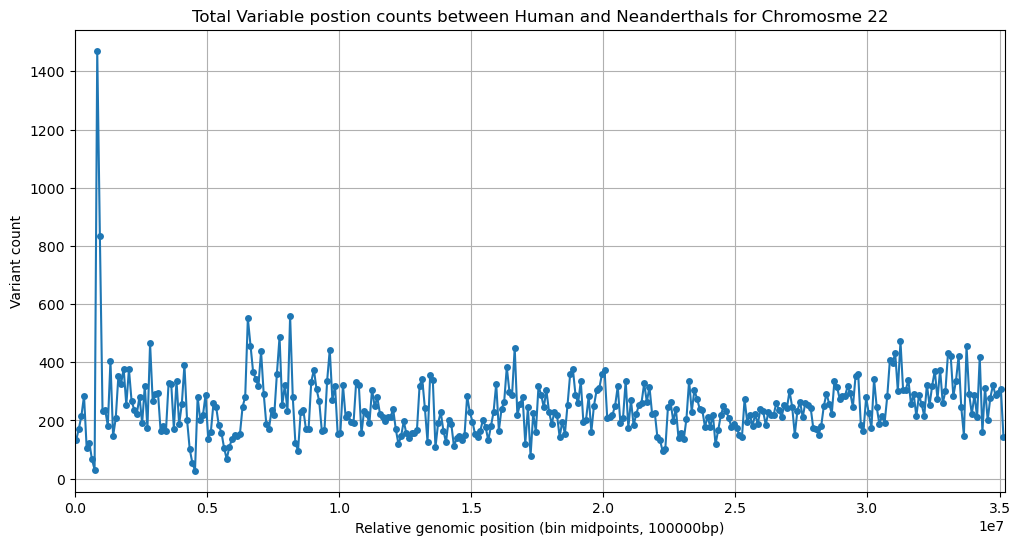

In [154]:
chunk_pos_df['rel_mid'] = (chunk_pos_df['start_pos'] + chunk_pos_df['end_pos']) // 2 - min_pos + 1
#print(chunk_pos_df)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=chunk_pos_df,
    x='rel_mid',
    y='total_variation_ct',
    marker="o",
    markersize=5,
    markeredgewidth=0 
)

plt.xlim(0,max(chunk_pos_df['rel_mid'])+chunk_size/2)
plt.xlabel(f"Relative genomic position (bin midpoints, {chunk_size}bp)")
plt.ylabel("Variant count")
plt.title('Total Variable postion counts between Human and Neanderthals for Chromosme 22')
plt.grid(True)
plt.savefig(f'Variable_postions_binned{chunk_size}bp.png', dpi=300, bbox_inches="tight")

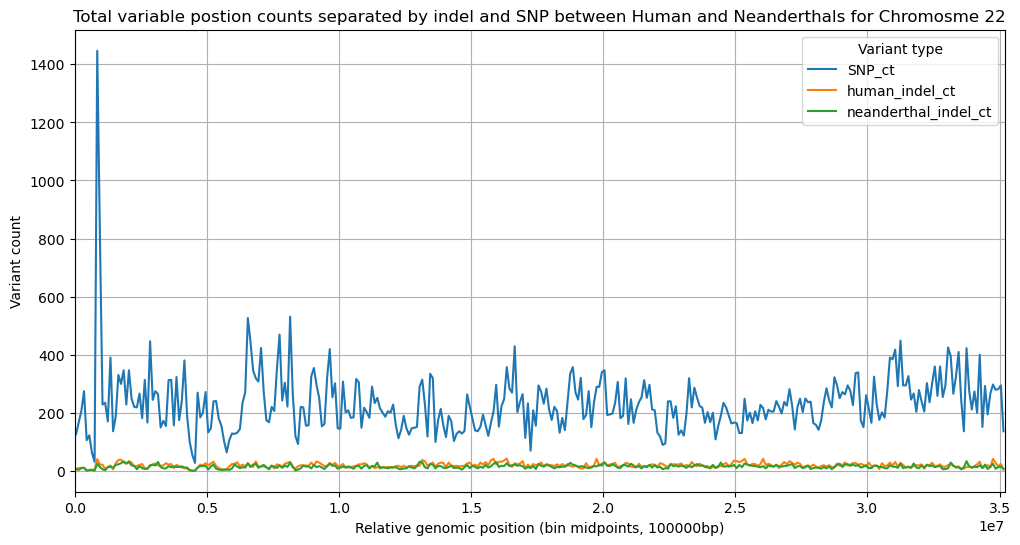

In [155]:
plot_df = chunk_pos_df.melt(
    id_vars=['rel_mid'],
    value_vars=['SNP_ct', 'human_indel_ct', 'neanderthal_indel_ct'],
    var_name='VariantType',
    value_name='Count'
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=plot_df,
    x='rel_mid',
    y='Count',
    hue='VariantType' #removed the markers, too busy with 3 lines
)

plt.xlim(0,max(chunk_pos_df['rel_mid'])+chunk_size/2)
plt.xlabel(f"Relative genomic position (bin midpoints, {chunk_size}bp)")
plt.ylabel("Variant count")
plt.title('Total variable postion counts separated by indel and SNP between Human and Neanderthals for Chromosme 22')
plt.grid(True)
plt.grid(True)
plt.legend(title="Variant type")
plt.savefig(f'BONUS_Variable_postions_binned{chunk_size}bp_Indel_SNP_separated.png', dpi=300, bbox_inches="tight")